# Ring resonator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt5
import meep as mp

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import scipy.constants
import math

from IPython.display import clear_output

import os
import fnmatch
import imageio
import json 

details = {}

## Design of the optical circuit

Design of the geometry of the optical component and set the simulation parameters.

In [2]:
# if plain is True no image will be saved during the simulation
plain = True
# give that plain is False, if animation is True the simulation will produce an .mp4 animation, otherwise it will produce .gif animation
animation = False

Find the resonance of the ring using the Harminv alghoritm, while using a source emitting a Gaussian wave.

In [3]:
n = 1.7    # Si is 3.5
w = 0.5
r = 2    # usually microrings are 5 um
dist = 0.4

pad = 4
dpml = 1
sxy = 2 * (r + w + dpml + pad) # size

In [4]:
print(f'FSR = {1 / (2*np.pi*r) / n} c/um')

m=15
# print(f'l_0 = {n * 2*np.pi*r / m} um')
print(f'f_0 = {1 / (n * 2*np.pi*r / m)} c/um for mode m={m}')

FSR = 0.04681027737996922 c/um
f_0 = 0.7021541606995383 c/um for mode m=15


In [5]:
resolution = 16
runtime = 1000
gaussian_runtime = 400

fcen = 0.702
df = 0.05
nfreq = 2000

     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)


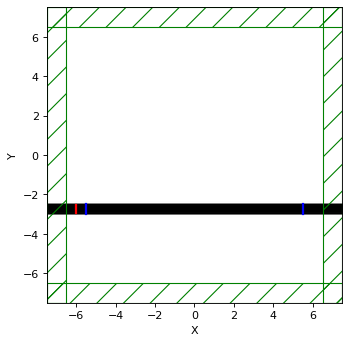

-----------
Initializing structure...
time for choose_chunkdivision = 0.000377893 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.150738 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 209.84375/600.0 = 35.0% done in 4.0s, 7.4s to go
on time step 6720 (time=210), 0.000595305 s/step
Meep progress: 434.875/600.0 = 72.5% done in 8.0s, 3.0s to go
on time step 13924 (time=435.125), 0.000555312 s/step
run 0 finished at t = 600.0 (19200 timesteps)


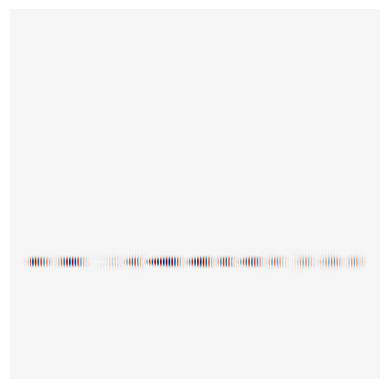

     cylinder, center = (0,0.4,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.4,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)


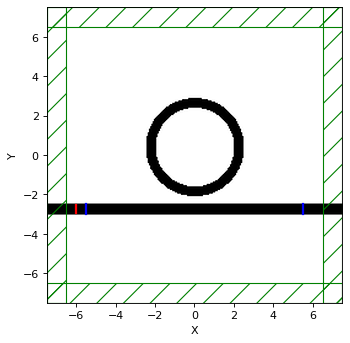

-----------
Initializing structure...
time for choose_chunkdivision = 0.000473976 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.4,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.4,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.257111 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 218.4375/600.0 = 36.4% done in 4.0s, 7.0s to go
on time step 6999 (time=218.719), 0.000571528 s/step
Meep progress: 398.125/600.0 = 66.4% done in 8.0s, 4.1s to go
on time step 12749 (time=398.406), 0.000695661 s/step
Meep progress: 591.40625/600.0 = 98.6% done in 12.0s, 0.2s to go
on time step 18939 (time=591.844), 0.00064626 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028231561518103, -0.00048462503481265436, 725.1205629765976, 0.025596115707343138, -0.023579307541543974+0.00995878482371146i, 1.9258647576737472e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)


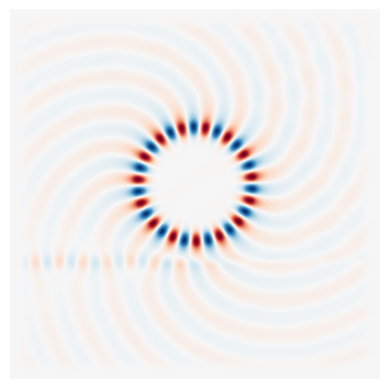

In [6]:
y_ring = dist
y_wg = -r-w-w/2

c1 = mp.Cylinder(radius = r + w, material = mp.Medium(index=n), center=mp.Vector3(0,y_ring,0))
c2 = mp.Cylinder(radius = r, material = mp.Medium(index=1.), center=mp.Vector3(0,y_ring,0))
guide = mp.Block(mp.Vector3(sxy, w, 0), center= mp.Vector3(0,y_wg,0), material = mp.Medium(index=n))

src = mp.Source(
    mp.GaussianSource(fcen, fwidth=df),
    mp.Ez,
    center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
    size=mp.Vector3(0,0.8*w,0)
    )

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0 ,w, 0),
                center=mp.Vector3(sxy/2 - dpml - 1, y_wg, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,w, 0),
                center=mp.Vector3(-sxy/2 + dpml + 1, y_wg, 0),
            )

for norma in ['Waveguide', 'Ring']:
    if (norma == 'Ring'):
        sim.reset_meep()
        geometry = [c1,c2,guide]
   
        if (not plain):
            f = plt.figure(dpi=600)
            animate = mp.Animate2D(sim, mp.Ez, f=f)
            plt.close()
    elif (norma == 'Waveguide'):
        geometry = [guide]
    
    sim = mp.Simulation(
        cell_size=mp.Vector3(sxy,sxy),
        geometry=geometry,
        sources=[src],
        resolution=resolution,
        boundary_layers=[mp.PML(dpml)]
        )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    plt.figure(dpi=80)
    sim.plot2D()
    plt.show()

    if (norma == 'Ring'):
        h=mp.Harminv(mp.Ez, mp.Vector3(r + 0.3*w, y_ring, 0), fcen, df)
        sim.load_minus_flux_data(refl, scatt_refl_data)
        if (plain):
            sim.run(mp.after_sources(h), until_after_sources=gaussian_runtime)
        else:
            if (animation):
                sim.run(mp.at_every(2, animate),
                        mp.after_sources(h), until_after_sources=gaussian_runtime)
                animate.to_mp4(15, './Ring.mp4')
            else:
                sim.run(mp.at_every(2, animate),
                        mp.after_sources(h), until_after_sources=gaussian_runtime)
                animate.to_gif(15, './Ring.gif')    
    elif (norma == 'Waveguide'):
        sim.run(until_after_sources=gaussian_runtime)
        
    if (norma == 'Ring'):
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    elif (norma == 'Waveguide'):
        scatt_refl_data = sim.get_flux_data(refl)
        scatt_tran_flux_wg = mp.get_fluxes(tran)
    
    eps_data = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sxy,sxy), component=mp.Dielectric)
    ez_data = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sxy,sxy), component=mp.Ez)

    plt.figure()

    plt.imshow(np.flipud(np.fliplr(eps_data.transpose())), interpolation='spline36', cmap='binary')
    plt.imshow(np.flipud(np.fliplr(ez_data.transpose())), interpolation='spline36', cmap='RdBu', alpha=1)

    plt.axis('off')
    plt.show()

Plot the trasmission and reflection due to the ring.

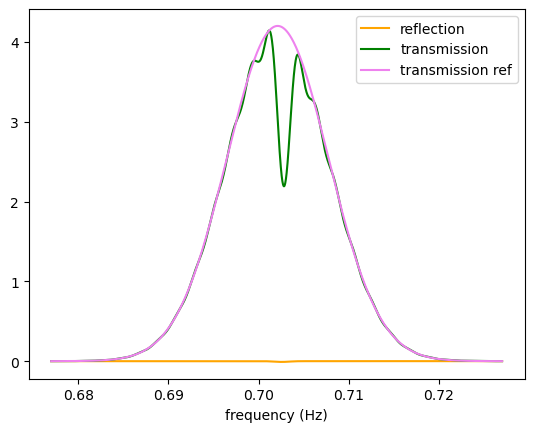

In [7]:
freqs = mp.get_flux_freqs(refl)

plt.figure()

plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')
plt.plot(freqs, scatt_tran_flux_wg, label='transmission ref', color='violet')

plt.xlabel('frequency (Hz)')

plt.legend(loc="upper right")
plt.show()

In [8]:
details['tran_wg_flux'] = scatt_tran_flux_wg
details['tran_ring_flux'] = scatt_tran_flux
details['refl_ring_flux'] = scatt_refl_flux

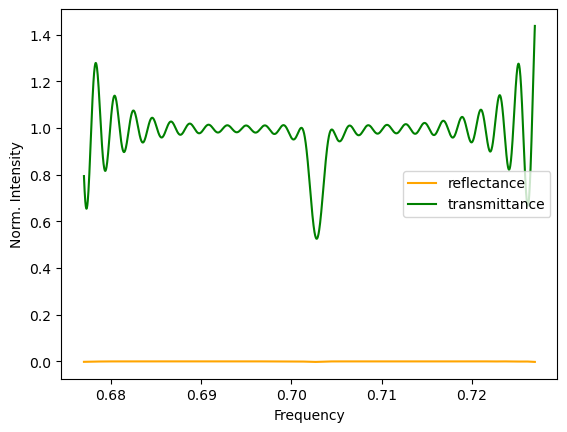

In [9]:
wl = []
Rs = []
Ts = []
Ref = []

for i in range(nfreq):
    wl = np.append(wl, freqs[i])
    Rs = np.append(Rs, scatt_refl_flux[i]/scatt_tran_flux_wg[i]) # il segno è legato all'orientazione del detector
    Ts = np.append(Ts, scatt_tran_flux[i]/scatt_tran_flux_wg[i])

plt.plot(wl, Rs, label='reflectance', color='orange')
plt.plot(wl, Ts, label='transmittance', color='green')
# plt.plot(wl[20:-20], Ts[20:-20], label='transmittance', color='green')

plt.xlabel('Frequency')
plt.ylabel('Norm. Intensity')

# plt.yscale("log")
plt.legend(loc='center right')
plt.show()

Modes found by Harminv (this alghoritm consider the fields as exponentially decaying)

In [10]:
h.modes

[Mode(freq=0.7028231561518103, decay=-0.00048462503481265436, Q=725.1205629765976, amp=(-0.023579307541543974+0.00995878482371146j), err=(1.9258647576737472e-11+0j))]

In [11]:
Q_factors = [data[2] for data in h.modes]
mode_amp = np.abs([data[3] for data in h.modes])
# ampiezze molto piccole possono essere artefatti numerici oppure h è stato posizionato in un punto sfigato
mode_freqs = [data[0] for data in h.modes]

<function matplotlib.pyplot.show(close=None, block=None)>

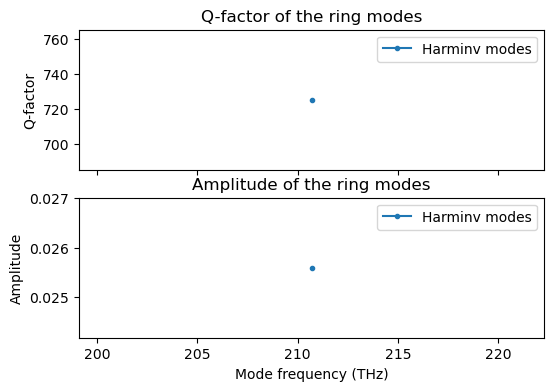

In [12]:
fig, ax = plt.subplots(2,1, figsize=(6,4))
ax[0].plot([ff*scipy.constants.c/10**6 for ff in mode_freqs], np.abs(Q_factors), '.-', label='Harminv modes')
ax[1].plot([ff*scipy.constants.c/10**6 for ff in mode_freqs], mode_amp, '.-', label='Harminv modes')

ax[0].set_title('Q-factor of the ring modes')
ax[0].set_ylabel('Q-factor')
ax[1].set_title('Amplitude of the ring modes')
ax[1].set_ylabel('Amplitude')

for axs in ax.flat:
    axs.set(xlabel='Mode frequency (THz)')
    axs.legend(loc='best')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axs in ax.flat:
    axs.label_outer()

plt.show

In [13]:
res_freq = mode_freqs[np.where(mode_amp == max(mode_amp))[0][0]]
print(f'The frequency with the highest amplitude is {res_freq} c/um')
print(f'The frequency with the highest amplitude is {res_freq*scipy.constants.c/10**6} THz')

The frequency with the highest amplitude is 0.7028231561518103 c/um
The frequency with the highest amplitude is 210.70108152206905 THz


## Switching to a continuous source

     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)


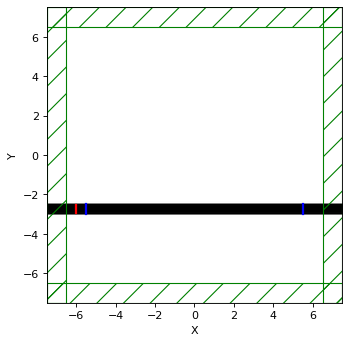

-----------
Initializing structure...
time for choose_chunkdivision = 0.000323057 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.135892 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 88.0/1000.0 = 8.8% done in 4.0s, 41.5s to go
on time step 2819 (time=88.0938), 0.00141915 s/step
Meep progress: 179.6875/1000.0 = 18.0% done in 8.0s, 36.5s to go
on time step 5755 (time=179.844), 0.00136293 s/step
Meep progress: 271.03125/1000.0 = 27.1% done in 12.0s, 32.3s to go
on time step 8679 (time=271.219), 0.00136831 s/step
Meep progress: 365.625/1000.0 = 36.6% done in 16.0s, 27.8s to go
on time step 11707 (time=365.844), 0.00132137 s/step
Meep progress: 459.25/1000.0 = 45.9% done in 20.0s, 23.6s to go
on time step 14705 (time=459.531), 0.00133469 s/step
Meep progress: 545.0625/1000.0 = 54.5% done in 24.0s, 20.0s to go
on time step 17449 (time=545.281), 0.00145795 s/step
Meep progress: 631.59375/1000.0 = 63.2% done in 28.0s, 16.3s to go
on time step 20222 (time=631.938), 0.00144279 s/step
Meep progress: 724.375/1000.0 = 72.4% done in 32.0s, 12.2s to go
on time step 23192 (time=724.75), 0.00134718 s/step
Meep progress: 820.4375/1000.0 = 82.0% done in 36.0s, 7.9s to

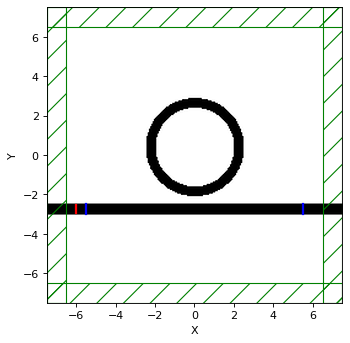

-----------
Initializing structure...
time for choose_chunkdivision = 0.000443935 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.4,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.4,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.30181 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 81.34375/1000.0 = 8.1% done in 4.0s, 45.2s to go
on time step 2612 (time=81.625), 0.00153171 s/step
Meep progress: 166.5/1000.0 = 16.6% done in 8.0s, 40.1s to go
on time step 5337 (time=166.781), 0.00146824 s/step
Meep progress: 252.84375/1000.0 = 25.3% done in 12.0s, 35.5s to go
on time step 8100 (time=253.125), 0.00144772 s/step
Meep progress: 344.28125/1000.0 = 34.4% done in 16.0s, 30.5s to go
on time step 11026 (time=344.562), 0.00136737 s/step
Meep progress: 437.75/1000.0 = 43.8% done in 20.0s, 25.7s to go
on time step 14021 (time=438.156), 0.00133585 s/step
Meep progress: 532.09375/1000.0 = 53.2% done in 24.0s, 21.1s to go
on time step 17037 (time=532.406), 0.00132665 s/step
Meep progress: 628.3125/1000.0 = 62.8% done in 28.0s, 16.6s to go
on time step 20118 (time=628.688), 0.00129891 s/step
Meep progress: 722.0/1000.0 = 72.2% done in 32.0s, 12.3s to go
on time step 23119 (time=722.469), 0.00133346 s/step
Meep progress: 806.75/1000.0 = 80.7% done in 36.0s, 8.6s to 

In [14]:
src = mp.Source(
    mp.ContinuousSource(res_freq),
    mp.Ez,
    center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
    size=mp.Vector3(0,0.8*w,0)
    )

for norma in ['Waveguide', 'Ring']:
    if (norma == 'Ring'):
        sim.reset_meep()
        geometry = [c1,c2,guide]
    elif (norma == 'Waveguide'):
        geometry = [guide]
    
    sim = mp.Simulation(
        cell_size=mp.Vector3(sxy,sxy),
        geometry=geometry,
        sources=[src],
        resolution=resolution,
        boundary_layers=[mp.PML(dpml)]
        )

    tran = sim.add_flux(res_freq, df, nfreq, trans_fr)
    refl = sim.add_flux(res_freq, df, nfreq, refl_fr)

    plt.figure(dpi=80)
    sim.plot2D()
    plt.show()

    if (norma == 'Ring'):
        sim.load_minus_flux_data(refl, scatt_refl_data)
        sim.run(until=runtime)
    elif (norma == 'Waveguide'):
        sim.run(until=runtime)
        
    if (norma == 'Ring'):
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    elif (norma == 'Waveguide'):
        scatt_refl_data = sim.get_flux_data(refl)
        scatt_tran_flux_wg = mp.get_fluxes(tran)

In [15]:
def fit_sin(xx, A, w, p):
    return A * np.sin(w * xx + p)

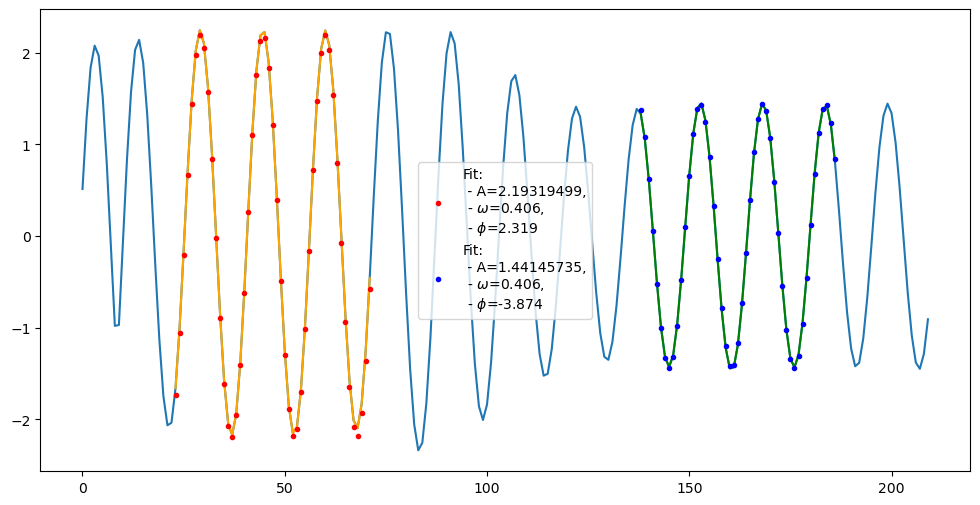

The phase difference is -6.19336129385082


In [16]:
ez_data = sim.get_array(center= mp.Vector3(0, y_wg, 0),
                        size=mp.Vector3(sxy-2*dpml, w),
                        component=mp.Ez)
ez_profile = np.sum(ez_data, axis=1)

outer_border=int(resolution*0.5 + 15)
inner_border=int(resolution*0.5 + 25)

before_start = outer_border
before_end = int(len(ez_profile)/2 - inner_border)
after_start = len(ez_profile) - before_end
after_end = len(ez_profile) - before_start

before_field = ez_profile[before_start:before_end]
after_field = ez_profile[after_start:after_end]

ft_before = np.fft.rfft(before_field)
ft_after = np.fft.rfft(after_field)
freq = np.fft.rfftfreq(len(before_field), d=1)

before_peak = np.argmax(np.abs(ft_before[1:])) + 1
after_peak = np.argmax(np.abs(ft_after[1:])) + 1

# fig, ax = plt.subplots(1, 1, figsize=(6,3))
# ax.plot(freq, np.abs(ft_before), 'b.')
# ax.plot(freq[before_peak], np.abs(ft_before)[before_peak], 'rx')

# plt.show()

popt_before, _ = curve_fit(fit_sin, np.arange(before_start, before_end), before_field, p0=[max(before_field)*1.5, 2*np.pi*freq[before_peak] , 0],
                           bounds=[[0,0,-np.inf], np.inf], maxfev=10000)
popt_after, _ = curve_fit(fit_sin, np.arange(after_start, after_end), after_field, p0=[max(after_field)*1.5, 2*np.pi*freq[after_peak], 0],
                          bounds=[[0,0,-np.inf], np.inf], maxfev=10000)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(np.arange(len(ez_profile)), ez_profile)
ax.plot(np.arange(before_start, before_end),before_field, c='orange')
ax.plot(np.arange(after_start, after_end),after_field, c='green')
ax.plot(np.arange(before_start, before_end),fit_sin(np.arange(before_start, before_end), *popt_before), 'r.', 
        label='Fit:\n - A=%5.8f,\n - $\omega$=%5.3f,\n - $\phi$=%5.3f' % tuple(popt_before))
ax.plot(np.arange(after_start, after_end),fit_sin(np.arange(after_start, after_end), *popt_after), 'b.',
        label='Fit:\n - A=%5.8f,\n - $\omega$=%5.3f,\n - $\phi$=%5.3f' % tuple(popt_after))

plt.legend(loc='center')
plt.show()

print(f'The phase difference is {popt_after[2]-popt_before[2]}')



In [17]:
details['wg_field'] = ez_profile.tolist()

## Transmission spectrum of the ring resonator

The source has been switched to a continuous source to produce a scan in frequency and measuring the average power transmitted as a response at different frequency. This spectrum shows the behaviour of a notch filter.

In [18]:
def lorentzian (xx, A, gamma, x0, c):
    return  A/math.pi * gamma/2 / ((xx - x0)**2 + (gamma/2)**2) + c

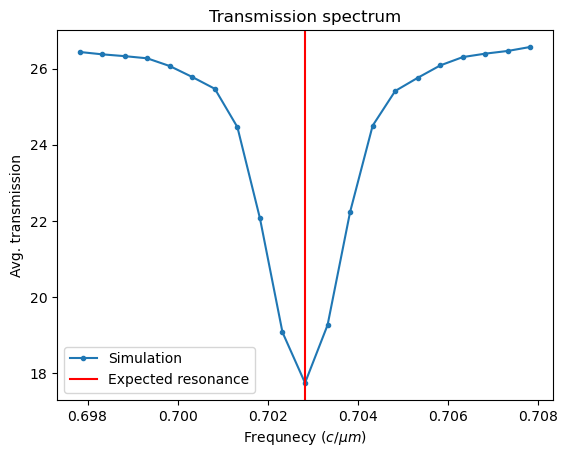

In [19]:
plot= False
nfreq_scan = 21
spectrum_runtime=600

print(f'The dimension of the simulation is {sxy}')
print(f'The risolution of the simulation is {resolution}')
print(f'The step of the simulation is {sxy*resolution}')

frequency = []
transmission_spectra = []

for f in np.linspace(res_freq-0.005, res_freq+0.005, nfreq_scan):
    for norma in ['Waveguide', 'Ring']:
        if (norma == 'Ring'):
            geometry = [c1,c2,guide]
        elif (norma == 'Waveguide'):
            geometry = [guide]
        
        src = mp.Source(
        mp.ContinuousSource(f),
        mp.Ez,
        center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
        size=mp.Vector3(0,w,0)
        )

        sim = mp.Simulation(
            cell_size=mp.Vector3(sxy,sxy),
            geometry=geometry,
            sources=[src],
            resolution=resolution,
            boundary_layers=[mp.PML(dpml)]
            )

        tran = sim.add_flux(res_freq, df, nfreq, trans_fr)
        refl = sim.add_flux(res_freq, df, nfreq, refl_fr)

        if (norma == 'Ring'):
            sim.load_minus_flux_data(refl, scatt_refl_data)
            sim.run(until=spectrum_runtime)
        elif (norma == 'Waveguide'):
            sim.run(until=spectrum_runtime)
            
        if (norma == 'Ring'):
            scatt_refl_flux = mp.get_fluxes(refl)
            scatt_tran_flux = mp.get_fluxes(tran)
        elif (norma == 'Waveguide'):
            scatt_refl_data = sim.get_flux_data(refl)
            # scatt_tran_flux_wg = mp.get_fluxes(tran)

    freqs = mp.get_flux_freqs(refl)

    if (plot):
        plt.plot(freqs, Ts, '.-', label='transmittance', color='green')

        plt.title(f'Source centerd in {f}Hz')
        plt.xlabel('frequency ($c / \mu m$)')
        plt.ylabel('Norm. Intensity')

        # plt.yscale("log")
        plt.legend(loc='center right')
        plt.show()
    else:
        clear_output()
        
    frequency += [f]
    transmission_spectra += [np.mean(scatt_tran_flux)]

    fig, ax = plt.subplots(1, 1)
    ax.plot(frequency, transmission_spectra, '.-', label='Simulation')
    ax.axvline(x=res_freq, c='r', label='Expected resonance')

    ax.set_title('Transmission spectrum')
    ax.set_xlabel('Frequnecy ($c / \mu m$)')
    ax.set_ylabel('Avg. transmission')

    plt.legend()
    plt.show()

    sim.reset_meep()
    

In [20]:
details['frequency_sweep'] = frequency
details['transmission_spectra'] = transmission_spectra

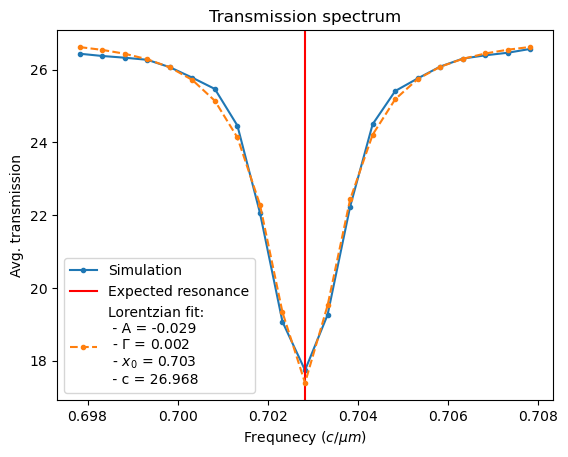

The Q factor of the MRR is 365.4629822411017


In [21]:
popt_spectra, _ = curve_fit(lorentzian, frequency, transmission_spectra, p0=[-0.03, 0.002, res_freq, 26])

fig, ax = plt.subplots(1, 1)
ax.plot(frequency, transmission_spectra, '.-', label='Simulation')
ax.axvline(x=res_freq, c='r', label='Expected resonance')

ax.plot(frequency, lorentzian(frequency, *popt_spectra), '.--', 
        label='Lorentzian fit:\n - A = %.3f\n - $\Gamma$ = %.3f\n - $x_0$ = %.3f\n - c = %.3f' % tuple(popt_spectra))

ax.set_title('Transmission spectrum')
ax.set_xlabel('Frequnecy ($c / \mu m$)')
ax.set_ylabel('Avg. transmission')

plt.legend()
plt.show()

Q_factor = popt_spectra[2]/popt_spectra[1]
print(f'The Q factor of the MRR is {Q_factor}')

## Phase difference as a function of the gap width

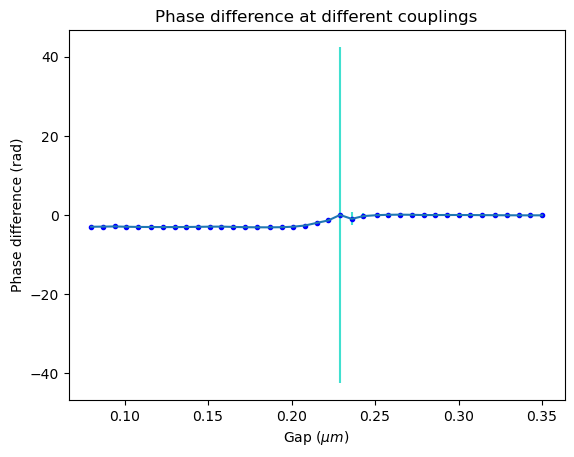

In [22]:
plot= False
ndist_scan = 39

outer_border=int(resolution*0.8)
inner_border=int(resolution*3)

before_start = outer_border
before_end = int(len(ez_profile)/2 - inner_border)
after_start = len(ez_profile) - before_end
after_end = len(ez_profile) - before_start
    
distance = []
phase_difference = []
phase_difference_err = []
field_profile = []

popt_before = [0,0,0]
popt_after = [0,0,0]

for dist in np.linspace(0.08, 0.35, ndist_scan):
    dist = np.round(dist, 3)

    c1 = mp.Cylinder(radius = r + w, material = mp.Medium(index=n), center=mp.Vector3(0,dist,0))
    c2 = mp.Cylinder(radius = r, material = mp.Medium(index=1.), center=mp.Vector3(0,dist,0))

# Gaussian source to estimate the resonance frequency
    src = mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        mp.Ez,
        center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
        size=mp.Vector3(0,0.8*w,0)
        )

    for norma in ['Waveguide', 'Ring']:
        if (norma == 'Ring'):
            sim.reset_meep()
            geometry = [c1,c2,guide]
        elif (norma == 'Waveguide'):
            geometry = [guide]
        
        sim = mp.Simulation(
            cell_size=mp.Vector3(sxy,sxy),
            geometry=geometry,
            sources=[src],
            resolution=resolution,
            boundary_layers=[mp.PML(dpml)]
            )

        refl = sim.add_flux(fcen, df, nfreq, refl_fr)

        if (norma == 'Ring'):
            h=mp.Harminv(mp.Ez, mp.Vector3(r + 0.3*w, dist, 0), fcen, df)
            sim.load_minus_flux_data(refl, scatt_refl_data)
            sim.run(mp.after_sources(h), until_after_sources=gaussian_runtime)
        elif (norma == 'Waveguide'):
            sim.run(until_after_sources=gaussian_runtime)
            scatt_refl_data = sim.get_flux_data(refl)

        sim.reset_meep()

    print('\n', 'Modes:\n', h.modes, '\n')
    mode_amp = np.abs([data[3] for data in h.modes])
    mode_freqs = [data[0] for data in h.modes]

    res_freq = mode_freqs[np.where(mode_amp == max(mode_amp))[0][0]]

# Continuous source to estimate the phase difference
    src = mp.Source(
            mp.ContinuousSource(res_freq),
            mp.Ez,
            center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
            size=mp.Vector3(0,0.8*w,0)
            )

    for norma in ['Waveguide', 'Ring']:
        if (norma == 'Ring'):
            sim.reset_meep()
            geometry = [c1,c2,guide]
        elif (norma == 'Waveguide'):
            sim.reset_meep()
            geometry = [guide]

        sim = mp.Simulation(
                cell_size=mp.Vector3(sxy,sxy),
                geometry=geometry,
                sources=[src],
                resolution=resolution,
                boundary_layers=[mp.PML(dpml)]
                )

        refl = sim.add_flux(res_freq, df, nfreq, refl_fr)

        if (norma == 'Ring'):
            h=mp.Harminv(mp.Ez, mp.Vector3(r + 0.3*w, dist, 0), fcen, df)
            sim.load_minus_flux_data(refl, scatt_refl_data)
            sim.run(until=runtime)
        elif (norma == 'Waveguide'):
            sim.run(until=runtime)
            scatt_refl_data = sim.get_flux_data(refl)
                        
    ez_data = sim.get_array(center= mp.Vector3(0, y_wg, 0),
                            size=mp.Vector3(sxy-2*dpml, w),
                            component=mp.Ez)
    ez_profile = np.sum(ez_data, axis=1)
    field_profile += [ez_profile]

    before_field = ez_profile[before_start:before_end]
    after_field = ez_profile[after_start:after_end]

    ft_before = np.fft.rfft(before_field)
    ft_after = np.fft.rfft(after_field)
    freq = np.fft.rfftfreq(len(before_field), d=1)

    before_peak = np.argmax(np.abs(ft_before[1:])) + 1
    after_peak = np.argmax(np.abs(ft_after[1:])) + 1

    popt_before, pcov_before = curve_fit(fit_sin, np.arange(before_start, before_end), before_field,
                                         p0=[max(before_field)*2, 2*np.pi*freq[before_peak], popt_before[2]],
                                         bounds=[[0,0,-np.inf], np.inf], maxfev=10000)
    popt_after, pcov_after = curve_fit(fit_sin, np.arange(after_start, after_end), after_field,
                                       p0=[max(after_field)*1.5, 2*np.pi*freq[after_peak], popt_after[2]],
                                       bounds=[[0,0,-np.inf], np.inf], maxfev=10000)

    if (plot):
        fig, ax = plt.subplots(1, 1, figsize=(12,6))

        ax.plot(np.arange(len(ez_profile)), ez_profile)
        ax.plot(np.arange(before_start, before_end),before_field, c='orange', label=f'{2*np.pi*freq[before_peak]}')
        ax.plot(np.arange(after_start, after_end),after_field, c='green', label=f'{2*np.pi*freq[after_peak]}')
        ax.plot(np.arange(before_start, before_end),fit_sin(np.arange(before_start, before_end), *popt_before), 'r.', 
                label='Fit:\n - A=%5.8f,\n - $\omega$=%5.5f,\n - $\phi$=%5.3f' % tuple(popt_before))
        ax.plot(np.arange(after_start, after_end),fit_sin(np.arange(after_start, after_end), *popt_after), 'b.',
                label='Fit:\n - A=%5.8f,\n - $\omega$=%5.5f,\n - $\phi$=%5.3f' % tuple(popt_after))

        plt.title(f'Filed at gap {dist} um')
        plt.legend()
        plt.show()
    else:
        clear_output()

    distance += [dist]

    # shift of phase in the desired range
    while (popt_after[2] > np.pi/2):
        popt_after[2] += -2*np.pi
    while (popt_after[2] < -np.pi*3/2 + 0.2):
        popt_after += 2*np.pi
    
    while (popt_before[2] > np.pi/2):
        popt_before[2] += -2*np.pi
    while (popt_before[2] < -np.pi*3/2 + 0.2):
        popt_before += 2*np.pi


    phase = popt_after[2]-popt_before[2]
    while (phase < -np.pi*3/2):
        phase += 2*np.pi
    while (phase > np.pi/2):
        phase += -2*np.pi

    phase_difference += [phase]
    phase_difference_err +=[np.sqrt(pcov_before[2][2]) + np.sqrt(pcov_after[2][2])]

    fig, ax = plt.subplots(1,1)

    ax.errorbar(distance, phase_difference, xerr = 0, yerr=phase_difference_err, ecolor='turquoise')
    ax.plot(distance, phase_difference, '.', color='b')


    ax.set_xlabel('Gap ($\mu m$)')
    ax.set_ylabel('Phase difference (rad)')
    ax.set_title('Phase difference at different couplings')
    plt.show()

In [23]:
details['distance_sweep'] = distance
details['phase_difference'] = phase_difference

In [24]:
for ii in range(len(field_profile)):
    field_profile[ii] = field_profile[ii].tolist()

details['field_profile'] = field_profile

In [25]:
details.keys()

dict_keys(['tran_wg_flux', 'tran_ring_flux', 'refl_ring_flux', 'wg_field', 'frequency_sweep', 'transmission_spectra', 'distance_sweep', 'phase_difference', 'field_profile'])

In [26]:
with open('dataRing.txt', 'w') as file: 
	file.write(json.dumps(details))

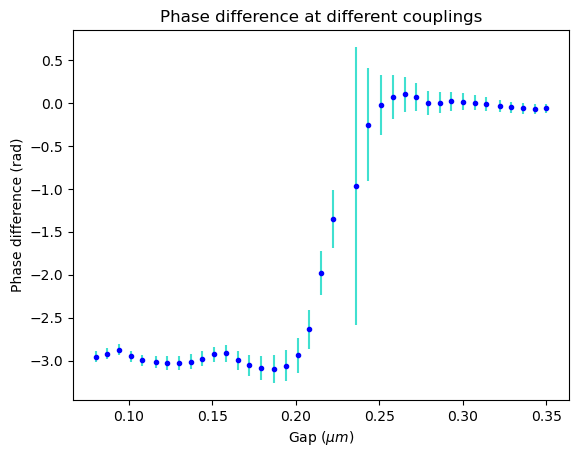

In [27]:
# reading the data from the file 
with open('dataRing.txt') as file:
    details = file.read()

details = json.loads(details)

outer_border=int(resolution*0.8)
inner_border=int(resolution*3)

phase_difference = []
phase_difference_err = []
field_profile = []
distance = details['distance_sweep']

popt_before = [0,0,0]
popt_after = [0,0,0]

for dist, ez_profile in zip(distance, details['field_profile']):
    before_start = outer_border
    before_end = int(len(ez_profile)/2 - inner_border)
    after_start = len(ez_profile) - before_end
    after_end = len(ez_profile) - before_start

    before_field = ez_profile[before_start:before_end]
    after_field = ez_profile[after_start:after_end]

    ft_before = np.fft.rfft(before_field)
    ft_after = np.fft.rfft(after_field)
    freq = np.fft.rfftfreq(len(before_field), d=1)

    before_peak = np.argmax(np.abs(ft_before[1:])) + 1
    after_peak = np.argmax(np.abs(ft_after[1:])) + 1

    popt_before, pcov_before = curve_fit(fit_sin, np.arange(before_start, before_end), before_field,
                                         p0=[max(before_field)*2, 2*np.pi*freq[before_peak], popt_before[2]],
                                         bounds=[[0,0,-np.inf], np.inf], maxfev=10000)
    popt_after, pcov_after = curve_fit(fit_sin, np.arange(after_start, after_end), after_field,
                                       p0=[max(after_field)*1.5, 2*np.pi*freq[after_peak], popt_after[2]],
                                       bounds=[[0,0,-np.inf], np.inf], maxfev=10000)

    if (plot):
        fig, ax = plt.subplots(1, 1, figsize=(12,6))

        ax.plot(np.arange(len(ez_profile)), ez_profile)
        ax.plot(np.arange(before_start, before_end),before_field, c='orange', label=f'{2*np.pi*freq[before_peak]}')
        ax.plot(np.arange(after_start, after_end),after_field, c='green', label=f'{2*np.pi*freq[after_peak]}')
        ax.plot(np.arange(before_start, before_end),fit_sin(np.arange(before_start, before_end), *popt_before), 'r.', 
                label='Fit:\n - A=%5.8f,\n - $\omega$=%5.5f,\n - $\phi$=%5.3f' % tuple(popt_before))
        ax.plot(np.arange(after_start, after_end),fit_sin(np.arange(after_start, after_end), *popt_after), 'b.',
                label='Fit:\n - A=%5.8f,\n - $\omega$=%5.5f,\n - $\phi$=%5.3f' % tuple(popt_after))

        plt.title(f'Filed at gap {dist} um')
        plt.legend()
        plt.show()

    # shift of phase in the desired range
    while (popt_after[2] > np.pi/2):
        popt_after[2] += -2*np.pi
    while (popt_after[2] < -np.pi*3/2):
        popt_after += 2*np.pi
    
    while (popt_before[2] > np.pi/2):
        popt_before[2] += -2*np.pi
    while (popt_before[2] < -np.pi*3/2):
        popt_before += 2*np.pi


    phase = popt_after[2]-popt_before[2]
    while (phase > np.pi/2):
        phase += -2*np.pi
    while (phase < -np.pi*3/2):
        phase += 2*np.pi

    phase_difference += [phase]
    phase_difference_err +=[np.sqrt(pcov_before[2][2]) + np.sqrt(pcov_after[2][2])]

remove_point = 21
distance.pop(remove_point)
phase_difference.pop(remove_point)
phase_difference_err.pop(remove_point)

fig, ax = plt.subplots(1,1)

ax.errorbar(distance, phase_difference, yerr=phase_difference_err, ecolor='turquoise', linestyle='None')
ax.plot(distance, phase_difference, '.', linestyle='None', color='b')


ax.set_xlabel('Gap ($\mu m$)')
ax.set_ylabel('Phase difference (rad)')
ax.set_title('Phase difference at different couplings')
plt.show()